# Project 2: Ames Housing Data and Kaggle Challenge - Part 2

In Part 2, we will build regression models to see which model is best able to predict sale price and resolve our problem. We will specifically explore the linear, ridge, lasso and elastic net regression models. In Part 1, from our Data Cleaning and EDA processes, we preliminarily eliminated features that were not best predictors of price. After data transformation, we now have significantly more features and some are definitely better predictors than others. Hence we will conduct feature selection to determine the best features that can predict our target variable the best. 


The modeling strategy and feature selection strategy is as follows:

    1. Build models based on all features
    2. Build models using filter methods (top 40 features that have highest correlation with sale price)
    3. Build models using backward elimination (using recursive feature elimination)
    3. Pick best model based on lowest RMSE on train

## Imports 

Let us import all necessary libraries first, followed by our data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE, RFECV
%matplotlib inline

In [2]:
train = pd.read_csv('../data/full_train_cleaned.csv')
test_maximal = pd.read_csv('../data/test_cleaned.csv')
train_set = pd.read_csv('../data/train_set_cleaned.csv')
validation_set = pd.read_csv('../data/validation_set_cleaned.csv')

In [3]:
#shape of datasets
display(train.shape)
display(test_maximal.shape)
display(train_set.shape)
display(validation_set.shape)

(2048, 163)

(879, 163)

(1638, 163)

(410, 163)

Test set has a column less which is expected since it will not contain the y variable. Train_set and Validation_set add up to have the same number of rows as Train data set (Which is the combination and train_set and validation_set). This shows there is no error in the data or when importing.

### Train Test Split

We have already split out data into train and validation. Now we will split them further to obtain our x and y variables. 

In [4]:
X_train_maximal = train_set.drop(columns = 'saleprice')
y_train = train_set['saleprice']
X_val_maximal = validation_set.drop(columns = 'saleprice')
y_val = validation_set['saleprice']
Original_X_train = train.drop(columns = 'saleprice')
Original_y_train = train['saleprice']
test = test_maximal.drop(columns='id')

## Modelling

In this section, we will first create models based on all of our features. Then we will proceed to dive into some feature selection methods to determine the best features that are able to predict sale prices the best. We will pick the best model that provides us with the lowest RMSE score on the validation dataset with _optimal_* number of features. 

_Optimal_* features will be identified from feature selection methods.

### All features

#### Null Regression and Baseline Score

##### Model 1 - Null Regression Model

In [5]:
# Create a dummy regressor
dummy_mean = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy_mean.fit(X_train_maximal, y_train)

#cross validation
round(np.abs(cross_val_score(dummy_mean, 
                             X_train_maximal,
                             y_train, 
                             cv=5,
                             scoring='neg_root_mean_squared_error').mean()),2)

78830.61

In [6]:
#conduct prediction using holdout test set
y_predict = dummy_mean.predict(X_val_maximal)
round(np.sqrt(mean_squared_error(y_predict, y_val)),2)

80405.6

The RMSE cross val score on the train is 78830.61 and 80405.60 on the test. The RMSE on the test is slightly worse, however this is expected as the model has not seen the test or in this case the validation set before and will generally perform worse.

##### Model 2 - Baseline Score, Linear Regression

From domain knowledge we know that area has always been one of the strongest predictors for house prices. We will create a base model with the `gr_liv_area` feature with represents the total ground living area above grade.

In [7]:
lr_baseline = LinearRegression()

X_train_baseline = X_train_maximal[['gr_liv_area']]

lr_baseline.fit(X_train_baseline, y_train)

#train RMSE
round(np.abs(cross_val_score(lr_baseline, 
                             X_train_baseline, 
                             y_train,
                             cv=5,
                             scoring='neg_root_mean_squared_error').mean()),2)

55175.73

In [8]:
y_predict = lr_baseline.predict(X_val_maximal[['gr_liv_area']])
round(np.sqrt(mean_squared_error(y_predict, y_val)),2)

54397.01

The baseline score to beat is 55175.73 for Train RMSE and 54397.01 for Test RMSE. 

There seems to be slight underfitting on the Train RMSE, this may be due to the lack of features that diallows the model from learning enough

Here is a short summary so far.

| Model | Method| Number of Features | Hyperparameters |Train RMSE (CV)| Validation RMSE |
| :-----------: | :-----------: | :-----------: |:-----------: |:-----------: |:-----------:|
| Model 1 : Null Regression    |Filter | 163 |None|78830.61 | 80405.60      |
| Model 2 : Baseline Score    |Filter|163 |None|55175.73 | 54397.01       |


#### Linear and Regularized Models

##### Model 3 - Linear Regression

In [9]:
#instantiate linear regression object
lr = LinearRegression()

#fit model
lr.fit(X_train_maximal, y_train)

#cross validation RMSE
round(np.abs(cross_val_score(lr, 
                             X_train_maximal, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

306969788473407.44

In [10]:
#conduct prediction using holdout test set
y_predictions = lr.predict(X_val_maximal)
round(np.sqrt(mean_squared_error(y_predictions, y_val)),2)

200823526500020.28

The train and test scores are absurdly large and the main reason is the high collinearity between features that developed after one hot encoding was done. Our preliminary filter methods removed features based on observations during EDA, however we had one hot encoded our nominal features after, resulting in more than 160 features as well as high collinearity.

The cost of high collinearity is that the coefficient estimates become very sensitive to small changes in the model or data and also result in high variability, hence the coefficients become absurdly large, as well as the RMSE scores.

##### Model 4 - Ridge Regression

In [11]:
#find best alpha
#visualise alpha values on log scale
r_alphas = np.logspace(0, 5, 200)

#instantiate ridgeCV object, use default cv, store cv values)
ridgecv = RidgeCV(alphas = r_alphas, store_cv_values=True)
ridgecv.fit(X_train_maximal, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        store_cv_values=True)

In [12]:
#optimal alpha
ridgecv.alpha_

9.54771611420806

In [13]:
#instantiate ridge based on best alpha
ridge = Ridge(alpha=ridgecv.alpha_)

#cross validation RMSE
round(np.abs(cross_val_score(ridge, 
                             X_train_maximal, 
                             y_train, 
                             cv=5,
                             scoring='neg_root_mean_squared_error').mean()),2)

24604.31

In [14]:
#test rmse
ridge.fit(X_train_maximal, y_train)
round(np.sqrt(mean_squared_error(ridge.predict(X_val_maximal), y_val)),2)

26339.3

We see a significant difference in the RMSE scores for linear regression and ridge regression as ridge regression induces penalty on the coefficient to reduce them and reduce overfitting. 

##### Model 5 - Lasso Regression

In [15]:
#insntatiate LassoCV
lassocv = LassoCV(n_alphas = 500)
lassocv.fit(X_train_maximal, y_train)

LassoCV(n_alphas=500)

In [16]:
#optimal alpha
lassocv.alpha_

65.6148305198901

In [17]:
#instantiate lasso based on best alpha
lasso = Lasso(alpha=lassocv.alpha_)
#cross validation RMSE
round(np.abs(cross_val_score(lasso, 
                             X_train_maximal, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

24525.69

In [18]:
#test rmse
lasso.fit(X_train_maximal, y_train)
round(np.sqrt(mean_squared_error(lasso.predict(X_val_maximal), y_val)),2)

26204.28

Similarly, we see the lasso regression performing well and even slightly better than ridge regression. Not only does Lasso regression penalise and shrink coefficients, it reduces them to absolute 0 as well to reduce loss.

##### Model 6 -Elastic Net Regression

In [19]:
enetcv = ElasticNetCV(n_alphas = 500, l1_ratio= np.arange(0.01, 1.0, 0.01),)
enetcv.fit(X_train_maximal, y_train)

ElasticNetCV(l1_ratio=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
             n_alphas=500)

In [20]:
#optimal alpha
enetcv.alpha_

63.5814963673456

In [21]:
enetcv.l1_ratio_

0.99

In [22]:
#cross validation
enet= ElasticNet(alpha = enetcv.alpha_, l1_ratio= enetcv.l1_ratio_)
round(np.abs(cross_val_score(enet, 
                             X_train_maximal, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

28968.58

In [23]:
enet.fit(X_train_maximal, y_train)
round(np.sqrt(mean_squared_error(enet.predict(X_val_maximal), y_val)),2)

30644.96

The results for the enet model are also good as compared to our baseline and linear regression models. 

##### Summary

| Model | Method| Number of Features | Hyperparameters |Train RMSE (CV Score)| Validation RMSE |
| :---------- | :-----------: | :-----------: |:-----------: |:-----------: |:-----------:|
| Model 1 : Null Regression    |- | 163 |None|78830.61 | 80405.60      |
| Model 2 : Baseline Score    |-|163 |None|55175.73 | 54397.01       |
| Model 3 : Linear Regression   |-|163 |None|3.67477e+14| 3.196167e+14 |
| Model 4 : Ridge Regression   |-|163 |alpha = 9.547716|24601.77| 26339.3|
| Model 5 : Lasso Regression   |-|163 |alpha = 65.61483|24525.69| 26204.28|
| Model 6 : ElasticNetRegression   |-|163 |alpha = 63.581497, l1_ratio=0.99|28968.58| 30644.96|

Let us take a look at an overview of all the models and their respective scores. Both Ridge and Lasso, L2 and L1 Regularisation performed much better than all other models, and this is not surprising as mentioned earlier. L2 and L1 Regularisation add penalty terms to penalise large coefficients and minimise the loss function. Additionally, they also reduce the multicollinearity amongst features. We see thus far that the best performing model is the Lasso Regression with an RMSE of 24545 on the train set.

### Top 40 features using Filter Method

Although our models performed well, 163 features is a high number of features and affects interpretability of models. In order to provide best recommendations of features to clients, it is essential that a model with high interpretability is produced.

We will select the top 40 features based on highest correlation with sale price.

In [24]:
#top 40 features that have highest correlation with sale price

top40 = train_set.corr()[['saleprice']].abs().sort_values(by='saleprice',ascending=False)[1:41]
top40

,saleprice
overall_qual,0.796907
gr_liv_area,0.715173
kitchen_qual,0.690887
total_bsmt_sf,0.666853
garage_area,0.646360
bsmt_qual_cond,0.606902
property_age,0.578831
garage_finish,0.557345
age_remod_add,0.550776
fireplace_qu,0.538770


In [25]:
top40_list = top40.index.to_list()

We will build the 4 regression models based on the filtered features.

In [26]:
X_train_40 = X_train_maximal[top40_list]
X_val_40 = X_val_maximal[top40_list]

##### Model 7 - Linear Regression

In [27]:
#instantiate linear regression object
lr = LinearRegression()

#fit model
lr.fit(X_train_40, y_train)

#cross validation RMSE
round(np.abs(cross_val_score(lr, 
                             X_train_40, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

26956.69

In [28]:
#conduct prediction using holdout test set
y_predictions = lr.predict(X_val_40)
round(np.sqrt(mean_squared_error(y_predictions, y_val)),2)

29516.21

Compared to Model 3, which was built using all 163 features, we see that the RMSE for both train and test is significantly lower, and this is to no surprise as reducing the number of features would also reduce collinearity amongst features and hence the coefficients are not _as_ sensitive to small changes in the model.

##### Model 8 - Ridge Regression

In [29]:
#find best alpha
#visualise alpha values on log scale
r_alphas = np.logspace(0, 5, 200)

#instantiate ridgeCV object, use default cv, store cv values)
ridgecv = RidgeCV(alphas = r_alphas, store_cv_values=True)
ridgecv.fit(X_train_40, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        store_cv_values=True)

In [30]:
#optimal alpha
ridgecv.alpha_

4.768611697714471

In [31]:
#instantiate ridge based on best alpha
ridge = Ridge(alpha=ridgecv.alpha_)

#cross validation RMSE
round(np.abs(cross_val_score(ridge, 
                             X_train_40, 
                             y_train, 
                             cv=5,
                             scoring='neg_root_mean_squared_error').mean()),2)

26906.22

In [32]:
#test rmse
ridge.fit(X_train_40, y_train)
round(np.sqrt(mean_squared_error(ridge.predict(X_val_40), y_val)),2)

29478.85

The Ridge Regression seems to have performed slightly worse than previously with 163 features.

##### Model 9 - Lasso Regression

In [33]:
#insntatiate LassoCV
lassocv = LassoCV(n_alphas = 500)
lassocv.fit(X_train_40, y_train)

LassoCV(n_alphas=500)

In [34]:
#optimal alpha
lassocv.alpha_

117.35646558559374

In [35]:
#instantiate lasso based on best alpha
lasso = Lasso(alpha=lassocv.alpha_)
#cross validation RMSE
round(np.abs(cross_val_score(lasso, 
                             X_train_40, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

26853.81

In [36]:
#test rmse
lasso.fit(X_train_40, y_train)
round(np.sqrt(mean_squared_error(lasso.predict(X_val_40), y_val)),2)

29399.64

We see a similar behaviour for Lasso Regression as well.

##### Model 10 - Elastic Net Regression

In [37]:
enetcv = ElasticNetCV(n_alphas = 500, l1_ratio= np.arange(0.01, 1.0, 0.01),)
enetcv.fit(X_train_40, y_train)

ElasticNetCV(l1_ratio=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
             n_alphas=500)

In [38]:
#optimal alpha
enetcv.alpha_

63.5814963673456

In [39]:
enetcv.l1_ratio_

0.99

In [40]:
#cross validation
enet= ElasticNet(alpha = enetcv.alpha_, l1_ratio= enetcv.l1_ratio_)
round(np.abs(cross_val_score(enet, 
                             X_train_40, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

30109.78

In [41]:
enet.fit(X_train_40, y_train)
round(np.sqrt(mean_squared_error(enet.predict(X_val_40), y_val)),2)

32043.79

##### Summary

| Model | Method| Number of Features | Hyperparameters |Train RMSE (CV Score)| Validation RMSE |
| :---------- | :-----------: | :-----------: |:-----------: |:-----------: |:-----------:|
| Model 1 : Null Regression    |- | 163 |None|78830.61 | 80405.60      |
| Model 2 : Baseline Score    |-|163 |None|55175.73 | 54397.01       |
| Model 3 : Linear Regression   |-|163 |None|3.0696979e+14| 2.0082353e+14 |
| Model 4 : Ridge Regression   |-|163 |alpha = 9.547716|24601.77| 26339.3|
| Model 5 : Lasso Regression   |-|163 |alpha = 65.61483|24525.69| 26204.28|
| Model 6 : ElasticNetRegression   |-|163 |alpha = 63.581497, 11_ratio=0.99|28968.58| 30644.96|
| Model 7 : Linear Regression   |Filter|40 |None|26956.69| 29516.21|
| Model 8 : Ridge Regression   |Filter|40 |alpha = 4.7686116|26906.22| 29478.85|
| Model 9 : Lasso Regression   |Filter|40 |alpha = 117.356465|26853.81| 29399.64|
| Model 10 : ElasticNetRegression   |Filter|40 |alpha = 63.581497,11_ratio=0.99|30109.78| 32043.79|

We see that the RMSE scores using the filter method have in fact _increased_ as compared to using all features. There are a couple of explanations for this.

1. This is a prime example that reducing the number of features benefits a simple OLS model, but it does not benefit regularized models. Regularized models are able to handle larger number of features, hence it is not necessary to reduce features to reduce RMSE. 

2. Less "important" features do in fact carry information that is relevant in model training and by not including them, we are not including "enough" information for our models to learn.

### Top Features using RFE

##### Model 11: Linear Regression

In [42]:
lr_rfe = LinearRegression()

rfe_lr = RFECV(lr_rfe, 
               cv=10,
               n_jobs=-1, 
               verbose=1)

rfe_lr.fit(X_train_maximal, y_train)

Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
F

RFECV(cv=10, estimator=LinearRegression(), n_jobs=-1, verbose=1)

In [43]:
rfe_lr.n_features_

16

In [44]:
X_train_lr_rfe = rfe_lr.transform(X_train_maximal)
X_val_lr_rfe = rfe_lr.transform(X_val_maximal)

In [45]:
#fit on X_train
lr_rfe.fit(X_train_lr_rfe, y_train)

#cross validation RMSE
round(np.abs(cross_val_score(lr_rfe, 
                             X_train_lr_rfe, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

68139.64

In [46]:
y_predictions = lr_rfe.predict(X_val_lr_rfe)
round(np.sqrt(mean_squared_error(y_predictions, y_val)),2)

69222.45

The train and test RMSE have actually increased as compared to using the filter methods. Although RFE selected top 16 features to be sufficient to produce the best RMSE, it seems that these features were still insufficient to provide enough information for the model, resulting in higher train and test errors.

##### Model 12: Ridge Regression

In [47]:
r_alphas = np.logspace(0, 5, 200)
ridgecv = RidgeCV(alphas = r_alphas, store_cv_values=True)
ridgecv.fit(X_train_maximal, y_train)
print('Best alpha {}'.format(ridgecv.alpha_))
ridge = Ridge(alpha=ridgecv.alpha_)

rfe_ridge = RFECV(ridge, 
                  cv=10,
                  n_jobs=-1, 
                  verbose=1)

rfe_ridge.fit(X_train_maximal, y_train)

Best alpha 9.54771611420806
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting es

Fitting estimator with 99 features.Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fit

Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
F

RFECV(cv=10, estimator=Ridge(alpha=9.54771611420806), n_jobs=-1, verbose=1)

In [48]:
rfe_ridge.n_features_

77

In [49]:
X_train_ridge_rfe = rfe_ridge.transform(X_train_maximal)
X_val_ridge_rfe = rfe_ridge.transform(X_val_maximal)

In [50]:
#fit on X_train
ridge.fit(X_train_ridge_rfe, y_train)

#cross validation RMSE
round(np.abs(cross_val_score(ridge, 
                             X_train_ridge_rfe, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

24193.81

In [51]:
y_predictions = ridge.predict(X_val_ridge_rfe)
round(np.sqrt(mean_squared_error(y_predictions, y_val)),2)

26576.22

There is definitely improvement in the overall train and test RMSE as compared to the RMSE achieved by top 40. As mentioned previously, regularised models such as Ridge and Lasso are capable of handling large features and capable of reducing multi-collinearity amongst features as well. In fact, the train and test RMSE are also better than the original models trained with all features. For Ridge regression, the coefficients are reduced to minimise RMSE, however it does not mean that the non-important features are removed, whereas, RFECV picks the top most important features.

##### Model 13: Lasso Regression

In [52]:
#insntatiate LassoCV
lassocv = LassoCV(n_alphas = 500)
lassocv.fit(X_train_maximal, y_train)
print('Best alpha {}'.format(lassocv.alpha_))
#instantiate lasso based on best alpha
lasso = Lasso(alpha=lassocv.alpha_)

rfe_lasso = RFECV(lasso, 
                  cv=10,
                  n_jobs=-1, 
                  verbose=1)

rfe_lasso.fit(X_train_maximal, y_train)

Best alpha 65.6148305198901

Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.

Fitting estimator with 33 features.Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fit

Fitting estimator with 99 features.Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fit

Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 fe

Fitting estimator with 33 features.Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fit

RFECV(cv=10, estimator=Lasso(alpha=65.6148305198901), n_jobs=-1, verbose=1)

In [53]:
rfe_lasso.n_features_

59

In [54]:
X_train_lasso_rfe = rfe_lasso.transform(X_train_maximal)
X_val_lasso_rfe = rfe_lasso.transform(X_val_maximal)

In [55]:
#fit on X_train
lasso.fit(X_train_lasso_rfe, y_train)

#cross validation RMSE
round(np.abs(cross_val_score(lasso, 
                             X_train_lasso_rfe, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

24262.86

In [56]:
y_predictions = lasso.predict(X_val_lasso_rfe)
round(np.sqrt(mean_squared_error(y_predictions, y_val)),2)

26185.69

A similar behavior is observed with Lasso Regression as well. Although the train and test RMSEs using RFECV are really close for both Lasso and Ridge regression, the Lasso regression only makes use of 59 features.

##### Model 14: Elastic Net Regression

In [57]:
#insntatiate LassoCV
enetcv = ElasticNetCV(n_alphas = 500, l1_ratio= np.arange(0.01, 1.0, 0.01),)
enetcv.fit(X_train_40, y_train)
#cross validation
enet= ElasticNet(alpha = enetcv.alpha_, l1_ratio= enetcv.l1_ratio_)

rfe_enet = RFECV(enet, 
                  cv=10,
                  n_jobs=-1, 
                  verbose=1)

rfe_enet.fit(X_train_maximal, y_train)



Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 f

Fitting estimator with 33 features.Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
Fitting estimator with 144 features.
Fitting estimator with 143 features.
Fitting estimator with 142 features.
Fitting estimator with 141 features.
Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fit

RFECV(cv=10, estimator=ElasticNet(alpha=63.5814963673456, l1_ratio=0.99),
      n_jobs=-1, verbose=1)

In [58]:
rfe_enet.n_features_

85

In [59]:
X_train_enet_rfe = rfe_enet.transform(X_train_maximal)
X_val_enet_rfe = rfe_enet.transform(X_val_maximal)

In [60]:
#fit on X_train
enet.fit(X_train_enet_rfe, y_train)

#cross validation RMSE
round(np.abs(cross_val_score(enet, 
                             X_train_enet_rfe, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

28933.29

In [61]:
y_predictions = enet.predict(X_val_enet_rfe)
round(np.sqrt(mean_squared_error(y_predictions, y_val)),2)

30671.18

The RMSE of both train and test has reduced has well using the RFECV method as compared to Filter methods.

##### Summary

| Model | Method| Number of Features | Hyperparameters |Train RMSE (CV Score)| Validation RMSE |
| :---------- | :-----------: | :-----------: |:-----------: |:-----------: |:-----------:|
| Model 1 : Null Regression    |- | 163 |None|78830.61 | 80405.60      |
| Model 2 : Baseline Score    |-|163 |None|55175.73 | 54397.01       |
| Model 3 : Linear Regression   |-|163 |None|3.0696979e+14| 2.0082353e+14 |
| Model 4 : Ridge Regression   |-|163 |alpha = 9.547716|24601.77| 26339.3|
| Model 5 : Lasso Regression   |-|163 |alpha = 65.61483|24525.69| 26204.28|
| Model 6 : ElasticNetRegression   |-|163 |alpha = 63.581497, 11_ratio=0.99|28968.58| 30644.96|
| Model 7 : Linear Regression   |Filter|40 |None|26956.69| 29516.21|
| Model 8 : Ridge Regression   |Filter|40 |alpha = 4.7686116|26906.22| 29478.85|
| Model 9 : Lasso Regression   |Filter|40 |alpha = 117.356465|26853.81| 29399.64|
| Model 10 : ElasticNetRegression   |Filter|40 |alpha = 63.581497,11_ratio=0.99|30109.78| 32043.79|
| Model 11 : Linear Regression   |RFE|16 |None|68139.64| 69222.45|
| Model 12 : Ridge Regression   |RFE|77 |alpha = 9.547716|24193.81| 26576.22|
| Model 13 : Lasso Regression   |RFE|59 |alpha = 65.61483|24262.86| 26185.69|
| Model 10 : ElasticNetRegression   |RFE|85 |alpha = 63.581497,11_ratio=0.99|28933.29| 30671.18|

To reiterate, we have seen improvements in overall RMSEs for the Ridge, Lasso and Elastic Net regressions using backward elimination. In fact these models have the lowest RMSEs thus far. However, we see that it did not benefit Linear Regression and a really low and comparable RMSE was only observed using the filter methods.

An interesting point to note is that despite low RMSE scores, the RFECV considered a higher number of features to be the best or the most important features for these models.

Our best model is _Model 13: Ridge Regression_ with the lowest RMSE on the train set. Let us further analyse our best model.

### Best Model Analysis

In [62]:
#fit on X_train
ridge.fit(X_train_ridge_rfe, y_train)

#cross validation RMSE
round(np.abs(cross_val_score(ridge, 
                             X_train_ridge_rfe, 
                             y_train, 
                             scoring='neg_root_mean_squared_error').mean()),2)

24193.81

In [63]:
y_predictions = ridge.predict(X_val_ridge_rfe)
round(np.sqrt(mean_squared_error(y_predictions, y_val)),2)

26576.22

#### Residual Plots

In [64]:
results = pd.DataFrame(y_predictions, columns=['Predictions'])

In [65]:
results['Actual'] = y_val
results['Residuals'] = results['Actual'] - results['Predictions']

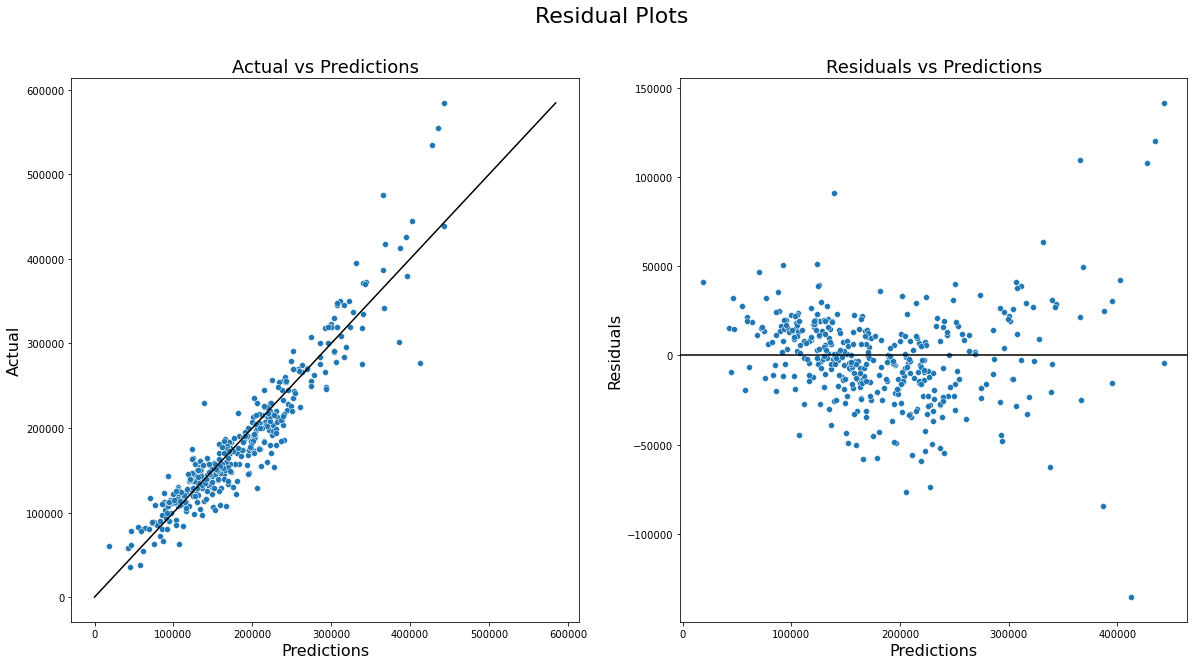

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=results, x='Predictions', y='Actual', ax=axes[0])
sns.lineplot(x=[0, np.max(y_val)], y=[0, np.max(y_val)], color='black', ax=axes[0])


sns.scatterplot(data=results, x='Predictions', y='Residuals', ax=axes[1])
axes[1].axhline(0, color='black')

plt.suptitle('Residual Plots', fontsize=22)
axes[0].set_title('Actual vs Predictions', fontsize=18)
axes[1].set_title('Residuals vs Predictions', fontsize=18)

for ax in axes:
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
   
    

Residual Plots are great measure to observe how trustworthy our regression results are. What we want to observe is whether our results are consistent with the random errors. On the left we have the actual values plotted against the predictions and on the right we have the residuals plotted against the predictions. 


We observe linearity from our predictions vs actual values to a large extent. However we observe some level of heteroscedasticity in our residual plots as the points scatter around y=0 and do not seem to be largely at random. 


This _could_ provide opportunity to raise concerns regarding our results despite using a regularised model. One way to fix this is to do a nonlinear transformation on our target value to further reduce heteroscedasticity.

#### Top Features of Best Model

### Production Model

We will put our production model to test by retraining on our entire train dataset and predict on the test data (test.csv) to understand how well it generalizes to unseen data and use this as our kaggle submission.

In [67]:
selectedfeatures = rfe_ridge.support_
train_bestfeatures = Original_X_train.iloc[:, selectedfeatures]

bestmodel = Ridge(alpha=ridgecv.alpha_)
bestmodel.fit(train_bestfeatures, Original_y_train)

Ridge(alpha=9.54771611420806)

In [68]:
y_predit_final = bestmodel.predict(test.iloc[:, selectedfeatures])

In [69]:
kaggle_submission = pd.DataFrame({'Id': test_maximal.id, 'Saleprice': y_predit_final})
kaggle_submission.to_csv('../data/kaggle_submission.csv', index=False)

**Final Kaggle Score**

![Kaggle](../images/Kaggle.png)

As we can see our final kaggle score of 28651.57 is not too far of our validation score of 26576.22, which means our model generalises fairly well to unseen data. It is expected to have a higher RMSE on the test as the model has never seen the test data before.

### Conclusion and Recommendations

#### Conclusion

We will observe the top features of our best model.

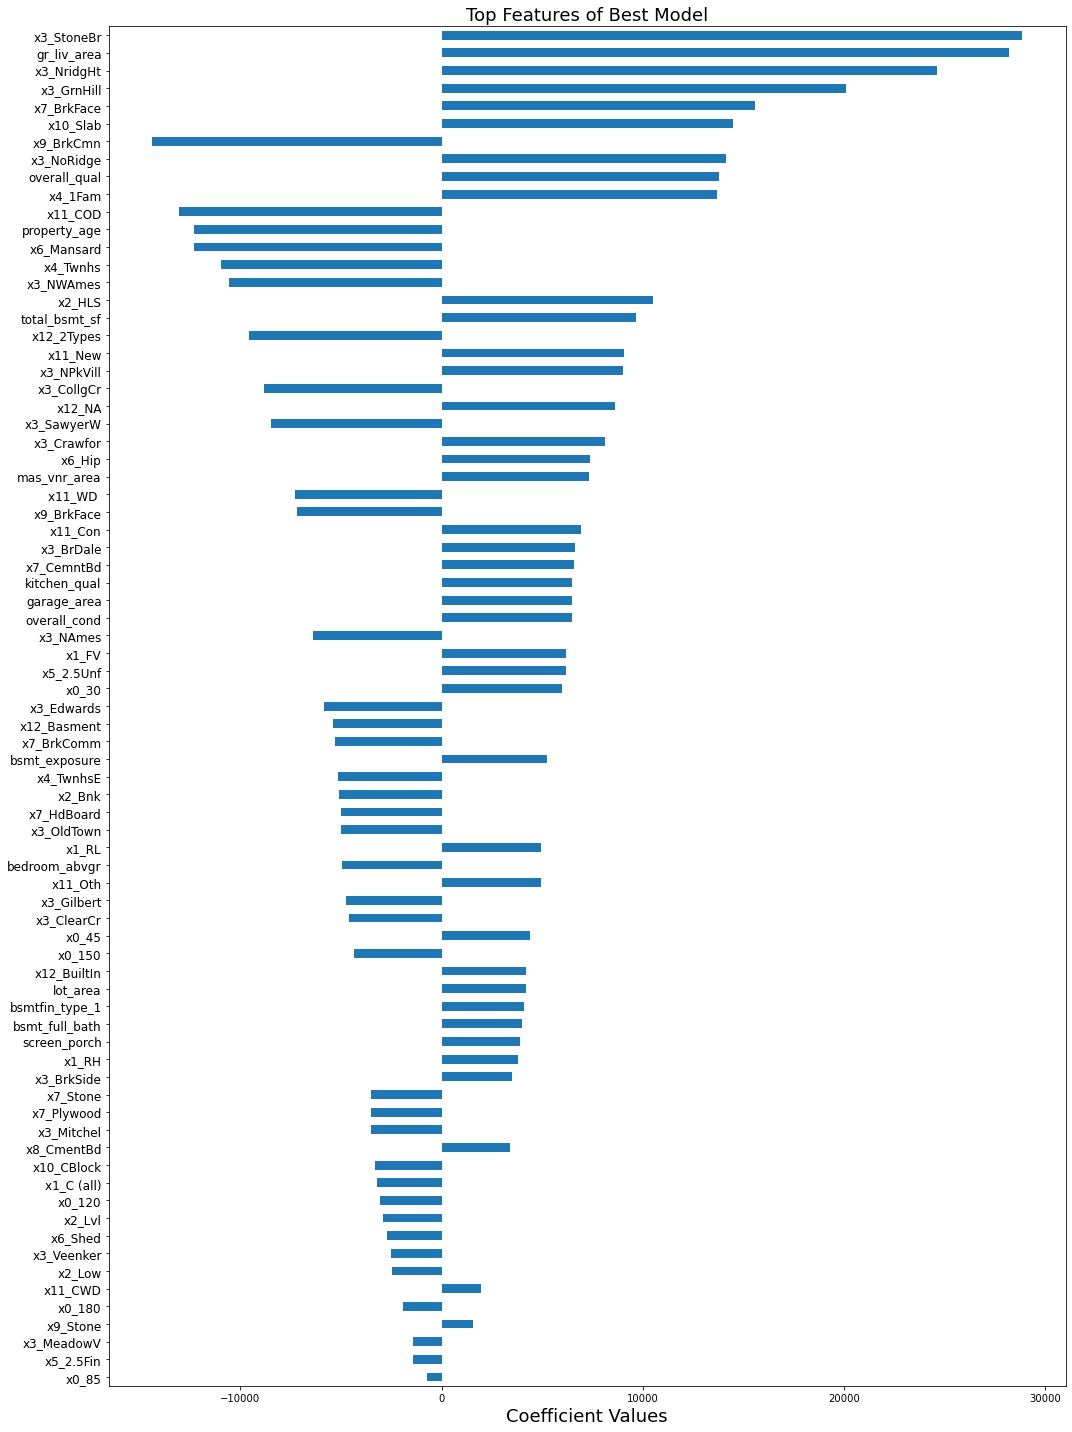

In [70]:
# get list of coefficients that are not 0
selectedfeatures = rfe_ridge.support_
train_bestfeatures = X_train_maximal.iloc[:, selectedfeatures]

bestmodel_coef = pd.DataFrame(bestmodel.coef_, index = train_bestfeatures.columns)                

# sort by absolute values
bestmodel_coef = bestmodel_coef.reindex(bestmodel_coef[0].abs().sort_values(ascending=True).index)

#top 30 coefficients
bestmodel_coef.plot.barh(figsize=(15,20), legend = None)
plt.title('Top Features of Best Model',fontsize=18)
plt.xlabel('Coefficient Values', fontsize=18)
plt.yticks(fontsize=12)
plt.tight_layout()

Based on our best model, our top feature turns out to be Stone Brook neighbourhood (x3_stoneBr) instead of `gr_liv_area`, which is surprising as we would usually expect area to be the best predictor of sale price.

Other than area and neighbourhood, we also see exterior covering and foundation of a property being strong predictors of sale price.

##### Interpreting Coefficients

In [73]:
bestmodel_coef.tail(1)

,0
x3_StoneBr,28854.441798


In [75]:
bestmodel.intercept_

176968.46087779058

Our features can be interpreted using the equation Y = B0 + B1X1 + ... + BxXx + e.

Based on the results above, the equation is

saleprice = 176968.46 + 28864.44(x3_stonebr)

This means one unit increase in living in stone brook neighbourhood results in sale price increasing by $28864.44.

##### Recommendations for Property Dealers and Buyers

Based on our top features, here are some notable recommendations for buyers

1. Property dealers/buyers should consider properties in Stone Brook, Northridge Heights and Green Hills for investment purposes as they yield higher sale prices. Will be more beneficial if property age is low as well. Also look into single-family detached properties/Hill side properties

2. Consider renovating to Brick Face exterior covering

3. Sell properties earlier as older properties yield lower sales

4. Avoid Masonry veneer types such as Brick Common.